In [7]:
# module import
from gekko import GEKKO
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# PV, Load Spec (Read Data)
data = pd.concat([pd.read_csv('PV_for_scheduling1.txt',  names =['PV']), pd.read_csv('Load_for_scheduling1.txt', names =['Load'])], axis=1)
pl = np.array(data, dtype=np.float32)
PV_Power = pl[:,0]
L_Power = pl[:,1]
Time = 0.25 # 15 minute

# Battery Spec (PCS / Capacity / Rate)
B_PCS = 250 # kW
B_Capacity = 750 # kWh
C_rate = 93/100
D_rate = 93/100

In [9]:
# Data for Plot
cost = 0
ESS_Charging = []
SOC_Data = []
PV_Data = []
Psrc_Data = []

In [10]:
#Initialize Model
m = GEKKO(remote=False)

In [11]:
#Declare the Variables

Psrc = [m.Var(value=0.0, lb= 0, ub=750) for i in range(96)]
SOC = [m.Var(value=50, lb=20, ub=80) for i in range(97)]
Pess = [m.Var(value=0, lb= -B_PCS, ub = B_PCS) for i in range(96)]
ESS_Charge = [m.Var(value=0, lb= -B_PCS, ub = 0) for i in range(96)] 
ESS_Discharge = [m.Var(value=0, lb= 0, ub = B_PCS) for i in range(96)]

In [12]:
r1 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r2 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r3 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r4 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r5 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r6 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r7 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r8 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r9 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]
r10 = [m.Var(value=0.0, lb=0, ub=75) for i in range(96)]

r11 = [m.Var(value=0.0, lb=0, ub=1, integer=True) for i in range(96)]
r11[0] = m.Param(value=1)
for i in range(1,96):
    r11[i] = m.if3(Psrc[i-1],1,0) 
Start_Cost = [m.if3(r11[i]*Psrc[i],0,1) for i in range(96)]


In [13]:
#Constraints

m.Equation(r11[0]== 1)
m.Equation(SOC[0]==50)
m.Equation(SOC[96]==50)  

for i in range(96):

    #Power Balance

    [m.Equation(Psrc[i] + Pess[i] + PV_Power[i] == L_Power[i])]
    
    [m.Equation(Psrc[i]== r1[i]+r2[i]+r3[i]+r4[i]+r5[i]+r6[i]+r7[i]+r8[i]+r9[i]+r10[i])]
    #[m.Equation(750*Start_Cost[i] >= Psrc[i])]
    #Prevent Charging and Discharging event simulataneously

    [m.Equation(ESS_Charge[i]*ESS_Discharge[i] <=1e-8)]
    [m.Equation(Pess[i] == ESS_Charge[i] + ESS_Discharge[i])]
    
    #SOC Equation
    [m.Equation(SOC[i+1]== SOC[i] - ESS_Discharge[i]*1/D_rate/B_Capacity*100*Time - ESS_Charge[i]*C_rate/B_Capacity*100*Time)]
    
for i in range(96):
    [m.Obj(217.275*r1[i] + 231.825*r2[i] + 246.375*r3[i] + 260.925*r4[i] + 275.475*r5[i] + 290.025*r6[i] + 304.575*r7[i] + 319.125*r8[i] + 333.675*r9[i] + 348.225*r10[i] + 32000*Start_Cost[i])]

In [14]:
#Set global options
m.solver_options = ['max_iter 2000']
m.options.IMODE = 3
m.options.solver = 3
#Solve Simulation
m.solve(dist=False)

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  2398
   Intermediates:  0
   Connections  :  0
   Equations    :  1152
   Residuals    :  1152
 
 Number of state variables:    2397
 Number of total equations: -  1056
 Number of slack variables: -  478
 ---------------------------------------
 Degrees of freedom       :    863
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public L

In [15]:
print ('Total Cost: ' + str(m.options.OBJFCNVAL))

Total Cost: 4260972.0352


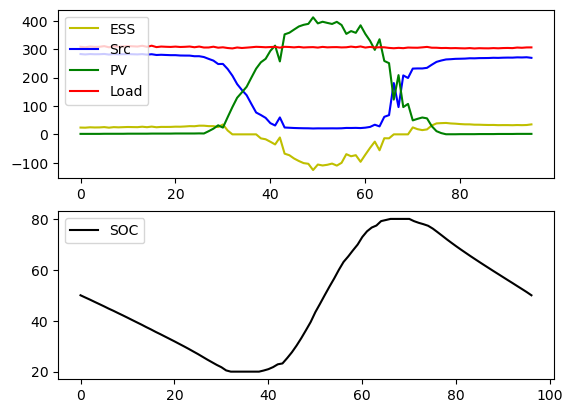

In [16]:
# Data Save for plot
for i in range(96):
	ESS_Charging.append(Pess[i])
	PV_Data.append(PV_Power[i])#-curt[i].varValue)
	Psrc_Data.append(Psrc[i])
	
for i in range(97):
	SOC_Data.append(SOC[i])

plt.subplot(211)
plt.plot(ESS_Charging, 'y', label='ESS')
plt.plot(Psrc_Data, 'b', label='Src')
plt.plot(PV_Data, 'g', label='PV')
plt.plot(L_Power, 'r', label='Load')
plt.legend(loc='upper left')
plt.subplot(212)
plt.plot(SOC_Data, 'k', label='SOC')
plt.legend(loc='upper left')
plt.show()